# **HYBRID CNN + BLSTM MODEL WITH PRE-TRAINED WORD EMBEDDINGS**

**IMPORT MODULES**

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from nltk import word_tokenize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**LOAD DATASET**

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/thesiss/French.csv')

In [ ]:
data

,Fake,text,clean_with_stopwords,final_clean
0,0,Il tente d'incendier sa femme : elle est indem...,il tente de incendier son femme lui être indem...,tente incendier femme indemne gravement bruler...
1,0,"Ça y est, Renaud a fait son retour sur scène !...",cela y être renaud avoir faire son retour sur ...,etre renaud avoir faire retour scene octobre a...
2,0,"Avec son tailleur rouge, quel message a voulu ...",avec son tailleur rouge quel message avoir vou...,tailleur rouge message avoir vouloir envoyer h...
3,0,Foot-Ligue 1 : tous les résultats de la 8ème j...,foot ligue tout le résultat de le èm journée h...,foot ligue tout resultat eme journee octobre m...
4,0,× S'abonner au podcast \nVous pouvez vous abon...,se abonner au podcast vous pouvoir vous abonne...,abonner podcast pouvoir abonner telechargement...
...,...,...,...,...
27811,1,97% de Libanaises refaites : L’ONU demande au ...,pourcent de libanais refaire l onu demande au ...,pourcent libanais refaire onu demande liban ar...
27812,1,Un réfugié syrien humilie et empêche une famil...,un réfugié syrien humilier et empêche un famil...,refugier syrien humilier empeche famill rom tr...
27813,1,Mehdi Meklat lance une banane à Christiane Tau...,mehdi meklat lance un banane à christiane taub...,mehdi meklat lance banane christiane taubira a...
27814,1,"En visite en Afghanistan, Marine Le Pen refuse...",en visite en afghanistan marine le pen refuse ...,visite afghanistan marine pen refuse participe...


In [ ]:
data['Fake'].value_counts()

1    14487
0    13329
Name: Fake, dtype: int64

In [ ]:
docs = data.final_clean.values
labels = data.Fake.values

In [ ]:
from collections import Counter
Counter(labels)

Counter({0: 13329, 1: 14487})

**TOKENIZATION**

In [ ]:
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1  # I add one because it starts counting from 0

In [ ]:
import nltk  # don't forget to do this step everytime in colab
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['Text_tokenised'] = data['final_clean'].apply(word_tokenize)

In [ ]:
data.head()

,Fake,text,clean_with_stopwords,final_clean,Text_tokenised
0,0,Il tente d'incendier sa femme : elle est indem...,il tente de incendier son femme lui être indem...,tente incendier femme indemne gravement bruler...,"[tente, incendier, femme, indemne, gravement, ..."
1,0,"Ça y est, Renaud a fait son retour sur scène !...",cela y être renaud avoir faire son retour sur ...,etre renaud avoir faire retour scene octobre a...,"[etre, renaud, avoir, faire, retour, scene, oc..."
2,0,"Avec son tailleur rouge, quel message a voulu ...",avec son tailleur rouge quel message avoir vou...,tailleur rouge message avoir vouloir envoyer h...,"[tailleur, rouge, message, avoir, vouloir, env..."
3,0,Foot-Ligue 1 : tous les résultats de la 8ème j...,foot ligue tout le résultat de le èm journée h...,foot ligue tout resultat eme journee octobre m...,"[foot, ligue, tout, resultat, eme, journee, oc..."
4,0,× S'abonner au podcast \nVous pouvez vous abon...,se abonner au podcast vous pouvoir vous abonne...,abonner podcast pouvoir abonner telechargement...,"[abonner, podcast, pouvoir, abonner, telecharg..."


In [ ]:
data['length'] = data['Text_tokenised'].str.len()

In [ ]:
maxlen = data['length'].max()

In [ ]:
maxlen

3521

**SPLIT DATA INTO TRAIN AND VALIDATE SETS**

In [ ]:
# divide the data into train/validate

from sklearn.model_selection import train_test_split


sentences_train, sentences_valid, y_train, y_valid = train_test_split(
    docs, labels, test_size=0.2, random_state=1000)

In [ ]:
Counter(labels)

Counter({0: 13329, 1: 14487})

**CONVERT TEXTS TO SEQUENCES**

In [ ]:
# use keras tokenizer to turn train and valid to sequence


X_train = t.texts_to_sequences(sentences_train)
X_valid = t.texts_to_sequences(sentences_valid)


print(sentences_train[2])
print(X_train[2])

jessica leeds ancien femme affaire lieu avion date debut anner accusation comme pieuvr mains partout source new york time rachel crook trentain receptionniste epoque lieu sortie ascenseur trump tower new york date accusation apres avoir simplement faire connaissance echanger poigne main avoir embrasser directement bouche source new york time jill harth travailler concours beaute lieu mar avoir lago domaine trump florid date janvier accusation admirer decoration seul chose souvenir ensuite etre pousse contre mur mettre main partout moi source new york time mindy mcgillivray assistant photograph lieu mar avoir lago domaine trump florid date janvier accusation etre plutot pelotage appuye plus simple attouchement etre tres pres centre fesse etre abasourdir source palm beach post natasha stoynoff collaborer magazine peopl lieu mar avoir lago domaine trump florid date decembre accusation trump avoir fermer porte derriere nous retourner espace quelque seconde train plaquer contre mur enfoncer

**APPLY POST-PADDING**

In [ ]:
# pad the short sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)

print(X_train[1, :])

[16082 16244   344 ...     0     0     0]


**EMBEDDING MATRIX**

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

**LOAD PRE-TRAINED WORD EMBEDDINGS**

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
        '/content/drive/MyDrive/thesiss/embeddings-l-model.vec',
        t.word_index, embedding_dim)

In [ ]:
# how many of the embedding vectors are nonzero

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.38649636663545983

In [ ]:
# how many of the embedding vectors are nonzero

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.38649636663545983

# **MODEL: CNN + BLSTM**

**BUILD THE MODEL**

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam,SGD

def create_model(vocab_size,embedding_dim,maxlen):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
        tf.keras.layers.Dropout(0.1),  
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.1),  
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    adam=Adam(learning_rate=0.001)
    model.compile(optimizer=adam, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
slice_size = [5000, 10000, 15000, 20000, 27815]

accuracies = []

for n_samples in slice_size:
    
    X_train_red=X_train[:n_samples]
    y_train_red=y_train[:n_samples]
    model=create_model(vocab_size,embedding_dim,maxlen)
    print('Number of samples: ',n_samples)
    history = model.fit(X_train_red, y_train_red,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=500)

   
    loss, acc = model.evaluate(X_valid, y_valid)
    accuracies.append(round(acc, 3))
    


Number of samples:  5000
Epoch 1/5
10/10 [==============================] - 26s 1s/step - loss: 0.6847 - accuracy: 0.5780 - val_loss: 0.6545 - val_accuracy: 0.7378
Epoch 2/5
10/10 [==============================] - 8s 840ms/step - loss: 0.5484 - accuracy: 0.7874 - val_loss: 0.4046 - val_accuracy: 0.8386
Epoch 3/5
10/10 [==============================] - 8s 843ms/step - loss: 0.2293 - accuracy: 0.9256 - val_loss: 0.2319 - val_accuracy: 0.9159
Epoch 4/5
10/10 [==============================] - 8s 838ms/step - loss: 0.0595 - accuracy: 0.9848 - val_loss: 0.2659 - val_accuracy: 0.9331
Epoch 5/5
174/174 [==============================] - 14s 79ms/step - loss: 0.2901 - accuracy: 0.9373
Number of samples:  10000
Epoch 1/5
20/20 [==============================] - 23s 829ms/step - loss: 0.6634 - accuracy: 0.6234 - val_loss: 0.5379 - val_accuracy: 0.7978
Epoch 2/5
20/20 [==============================] - 15s 738ms/step - loss: 0.2924 - accuracy: 0.8958 - val_loss: 0.1747 - val_accuracy: 0.9366
Ep

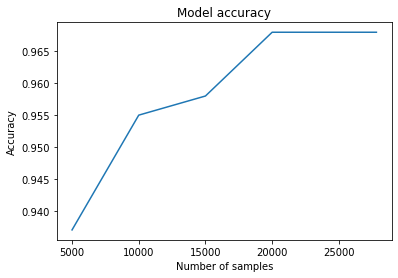

In [ ]:
import matplotlib.pyplot as plt
plt.plot(slice_size,accuracies)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of samples')
plt.show()